In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

from utils import *

import torch 
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import librosa
from librosa.sequence import dtw

import scipy.stats as stats


import sbi
from sbi import analysis as analysis
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from IPython.display import clear_output
import warnings
import os


warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Import and format data

In [2]:
main_dir = './DR8/'
dir_list = os.listdir(main_dir)[1:-1]

In [3]:
cmap = get_cmap("viridis")


## Get all syllables, words and sentences

In [4]:
# Chose only a subset of the data 
n_speaker = 2
n_sentence = -1

all_syllable_labels = []
all_aligned_words, all_aligned_sylls = [], []
sentences_syll = []
sentences_words = []

gaps = []

for dir in dir_list[:n_speaker]:
    for subdir in os.listdir(main_dir + dir)[:n_sentence]:
        if subdir[0]=='S':
            sylls = pd.read_csv(main_dir + dir + '/' + subdir + '/' + subdir +'.sylbtime',sep='\t', header=None, names=['onset', 'offset', 'label'])
            for i in range(len(sylls)):
                if sylls['label'][i][1:]=='#': 
                    gaps.append(main_dir + dir + '/' + subdir + '/' + subdir)
                    print("Gap found in sentence, skipping") 
                    continue
                    # The # symbol is used for gaps here, for now we remove sentences with gaps for simplicity 
                    # (and save the # symbol for the start/end of the sentence)
                else:
                    all_syllable_labels.append(sylls['label'][i][1:])

            sentences_syll.append(list(sylls['label']))

            words = pd.read_csv(main_dir + dir + '/' + subdir + '/' + subdir +'.WRD',sep=' ', header=None, names=['onset', 'offset', 'label'])
            

            word_list, syll_list = align_syll_words(sylls, words)
            all_aligned_words.extend(word_list)
            all_aligned_sylls.extend(syll_list)

            sentences_words.append(word_list)
            


unique_syllable_labels = list(np.unique(all_syllable_labels))
num_syll = len(unique_syllable_labels)
count_syll = {syll:len(np.where(np.array(all_syllable_labels)==syll)[0]) for syll in unique_syllable_labels} # number of occurence of each syllable


unique_words_sequences = []
for seq in all_aligned_sylls:
    if seq not in unique_words_sequences:
        unique_words_sequences.append(seq)
num_words = len(unique_words_sequences)
# count_words = {word:len(np.where(np.array(all_aligned_sylls)==word)[0]) for word in unique_words_sequences} # number of occurence of each word

Gap found in sentence, skipping
Gap found in sentence, skipping
Gap found in sentence, skipping


# Get spectrograms

In [5]:
bands=6 # number of frequency bands
target_time_steps=8 # number of interpolation points

syll2idx = {s: i for i, s in enumerate(unique_syllable_labels)}

syll2spectrogram = {s: np.zeros((bands,target_time_steps)) for s in unique_syllable_labels}

nans = []

for dir in dir_list[:n_speaker]:
    for subdir in os.listdir(main_dir + dir)[:n_sentence]:
        if subdir[0] == 'S':
            # fs, signal = read(main_dir + dir + '/' + subdir + '/' + subdir + '.wav')
            signal, fs =  librosa.load(main_dir + dir + '/' + subdir + '/' + subdir + '.wav', sr=None, mono=True)
            signal = signal.astype(np.float32)
            if np.isnan(signal).any():
                    print(f"NaN found in signal for {dir+'/'+subdir}")
            sylls = pd.read_csv(main_dir + dir + '/' + subdir + '/' + subdir + '.sylbtime',
                                sep='\t', header=None, names=['onset', 'offset', 'label'])

            for i in range(len(sylls)):
                onset, offset = int(sylls['onset'][i]), int(sylls['offset'][i])
                syll_signal = signal[onset:offset]

                syll_label = sylls['label'][i][1:]
                if syll_label == '#':
                    # print('# found, skipping')
                    continue
                syll_index = syll2idx[syll_label]
                
                

                S = reduced_interpolated_spectrogram(syll_signal, fs, bands=bands, target_time_steps=target_time_steps)
                if np.isnan(S).any():
                    print(f"NaN found in spectrogram for {dir+'/'+subdir}, skipping") # ignore syllables if there is a NaN in the spectrogram
                    nans.append(main_dir + dir + '/' + subdir + '/' + subdir)
                    continue

                syll2spectrogram[syll_label] += S / np.max(S.flatten()) # Normalize 


# Normalize by syllable count in dataset
for s in syll2spectrogram.keys():
    syll2spectrogram[s] /= count_syll[s]
    syll2spectrogram[s] /= np.max(syll2spectrogram[s])+1e-3

NaN found in spectrogram for FBCG1/SX352, skipping


In [6]:
for syll in syll2spectrogram:
    if np.isnan(syll2spectrogram[syll]).any():
        print("NaN")
        print(syll)


# Create syllable embeddings

### Compute DTW distances between spectrograms

100%|██████████| 184/184 [00:02<00:00, 85.07it/s]


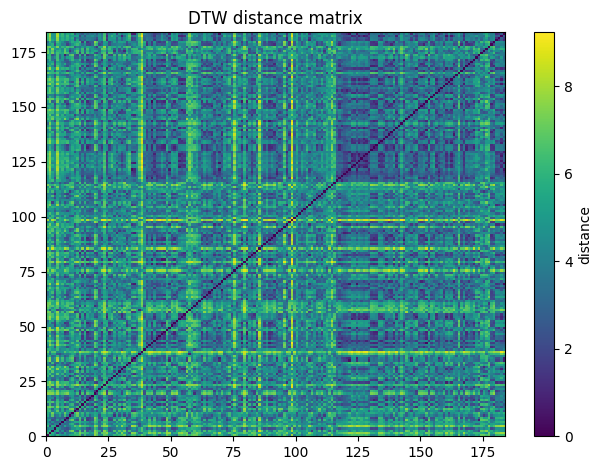

In [7]:
dtw_distances = np.zeros((num_syll, num_syll))
for i in tqdm(range(num_syll)):
    si = syll2spectrogram[unique_syllable_labels[i]]
    for j in range(num_syll):
        sj = syll2spectrogram[unique_syllable_labels[j]]
        d = dtw(si, sj)[0]
        dtw_distances[i,j] = d[-1][-1]

plt.figure()
plt.pcolormesh(dtw_distances)
plt.colorbar(label="distance")
plt.title("DTW distance matrix")
plt.tight_layout()
plt.show()
    

In [8]:
dtw_tensor = torch.tensor(dtw_distances)
dtw_tensor = (dtw_tensor - dtw_tensor.min()) / (dtw_tensor.max() - dtw_tensor.min())
embedding_dim = 8
init = torch.randn(num_syll, embedding_dim)*3.0
og_embedding = torch.clone(init)
embedding = nn.Parameter(init, requires_grad=True)


# Optimizer
optimizer = optim.Adam([embedding], lr=0.1)

# Loss function: MSE between pairwise distances and DTW
def distance_matrix(emb):
    # Compute all pairwise squared distances between embeddings
    diff = emb.unsqueeze(0) - emb.unsqueeze(1)  # (N, N, D)
    return (diff ** 2).sum(dim=2)  # (N, N)


In [9]:
num_epochs = 10000
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    
    pairwise_dists = distance_matrix(embedding)
    
    loss = ((pairwise_dists - dtw_tensor) ** 2).mean()
    
    loss.backward()
    optimizer.step()
      # after optimizer.step()

    if (epoch + 1) % 500 == 0:
      clear_output(wait=True)
      print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

100%|██████████| 10000/10000 [00:27<00:00, 365.06it/s]

Epoch 10000, Loss: 0.0037


# SBI


In [10]:
def build_simulator(embedding, syll2spectrogram, sigma=0.05):
    def simulator(theta):
        u = np.unique(list(syll2spectrogram.keys()))

        bands, target_time_steps = syll2spectrogram[u[0]].shape
        batch_size = theta.shape[0]
        x = torch.zeros((batch_size, bands * target_time_steps))
        for batch in range(batch_size):
            dists = torch.norm(embedding.detach() - theta[batch], dim=1).detach()
            i = int(torch.argmin(dists))            
            s = torch.tensor(syll2spectrogram[u[i]].flatten(), dtype=torch.float32)
            x[batch] = s + torch.randn_like(s)*sigma*torch.mean(s)*dists[i]*10

        return x

    return simulator


In [11]:
def build_simulator_morph(embedding, syll2spectrogram, T=1e-2):
    def simulator(theta):
        u = np.unique(list(syll2spectrogram.keys()))

        bands, target_time_steps = syll2spectrogram[u[0]].shape
        batch_size = theta.shape[0]
        x = torch.zeros((batch_size, bands * target_time_steps))
        for batch in range(batch_size):
            dists = torch.norm(embedding.detach() - theta[batch], dim=1).detach()
            S = np.sum(np.array([softmax_temperature(dists, T)[i] * syll2spectrogram[u[i]].flatten() for i in range(len(u))]), axis=0)           
            s = torch.tensor(S, dtype=torch.float32)
            x[batch] = s #+ torch.randn_like(s)*sigma*torch.mean(s)

        return x

    return simulator

In [12]:
simulator = build_simulator(embedding, syll2spectrogram)

lo = torch.tensor(np.min(embedding.detach().numpy(), axis=0))*1.1
hi = torch.tensor(np.max(embedding.detach().numpy(), axis=0))*1.1

prior = sbi.utils.BoxUniform(low=lo, high=hi)

In [13]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [14]:
# Create inference object. Here, NPE is used.
inference = NPE(prior=prior, density_estimator='mdn')

# generate simulations and pass to the inference object
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
inference = inference.append_simulations(theta.clone(), x.clone())


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
# train the density estimator and build the posterior
torch.autograd.set_detect_anomaly(True)  
density_estimator = inference.train(
    max_num_epochs=150 
)



 Neural network successfully converged after 58 epochs.

In [16]:
posterior = inference.build_posterior(density_estimator)

In [17]:
path_list = []
for dir in tqdm(dir_list[:n_speaker]):
    for subdir in tqdm(os.listdir(main_dir + dir)[:n_sentence]):
        if subdir[0]=='S':
            path = main_dir + dir + '/' + subdir + '/' + subdir
            if (path in gaps) or (path in nans):
                continue
            path_list.append(path)

print(f"{len(path_list)} directories")


100%|██████████| 2/2 [00:00<00:00, 199.49it/s]

15 directories


In [36]:
res_all = []
res_wp_syll_all = []
res_wp_words_all = []
resyll_all = []
resyll_by_count_all = {i+1:[] for i in range(count_syll[max(count_syll, key=lambda x : count_syll[x])])}
np.random.seed(42)
np.random.shuffle(path_list)
for path in tqdm(path_list[:]):
    # try:
        res, res_wp_syll, res_wp_words, resyll, resyll_by_count = sequential_inference_3d_words_sequences(
            path, 
            embedding, 
            posterior, 
            unique_words_sequences,all_aligned_sylls,  
            syll2spectrogram, syll2idx, count_syll,
            sigma=.05, 
            T1=1e0, T2=1e1, T3=1e0, 
            alpha=2., beta=.5)

        res_all.append(res)
        res_wp_syll_all.append(res_wp_syll)
        res_wp_words_all.append(res_wp_words)
        resyll_all.extend(resyll)
        for key in resyll_by_count:
            resyll_by_count_all[key].extend(resyll_by_count[key])


        # clear_output(wait=True)
    # except:
    #     print(f"Something went wrong with sentence {path}")


100%|██████████| 15/15 [02:32<00:00, 10.16s/it]


In [34]:
gc.collect()

0

Average accuracy
No Prior : 0.678
GT Prior : 1.0
Word Prior : 0.678

Syllable accuracy (No Prior) : 0.6030150753768844


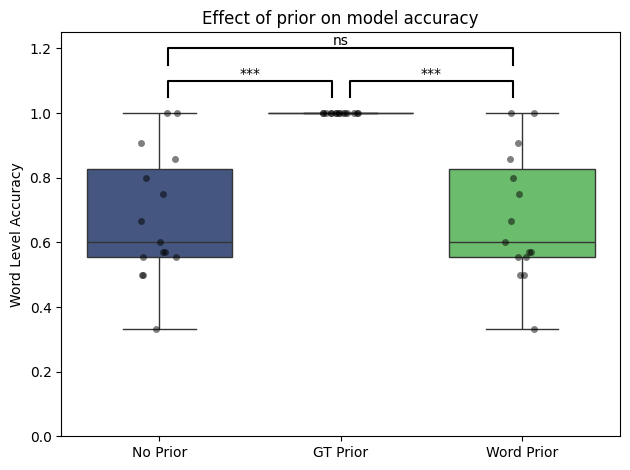

In [38]:
means = [np.mean(res) for res in res_all]
means_wp_syll = [np.mean(res) for res in res_wp_syll_all]
means_wp_words = [np.mean(res) for res in res_wp_words_all]

df = pd.DataFrame(np.array([means, means_wp_syll, means_wp_words]).T, columns=["No Prior", "GT Prior", "Word Prior"])
pvalue_wp_syll = stats.ttest_ind(a=df["No Prior"], b=df["GT Prior"]).pvalue
pvalue_wp_words = stats.ttest_ind(a=df["No Prior"], b=df["Word Prior"]).pvalue
pvalue_wp_comp = stats.ttest_ind(a=df["GT Prior"], b=df["Word Prior"]).pvalue

pvalues = {
    "syll":pvalue_wp_syll,
    "words":pvalue_wp_words,
    "comp":pvalue_wp_comp
}

symbols = {}

for key in pvalues.keys():
    pvalue = pvalues[key]
    if pvalue>.05:
        symbols[key] = 'ns'
    elif pvalue>0.01:
        symbols[key] = '*' 
    elif pvalue>0.001:
        symbols[key] = '**'
    else:
        symbols[key] = '***'

print("Average accuracy")
for name in df.columns:
    print(f"{name} : {df[name].mean().round(3)}")

print("")
print(f"Syllable accuracy (No Prior) : {np.mean(resyll_all)}")
fig = plt.figure()
sns.boxplot(df, palette='viridis')
sns.stripplot(df,color='black', jitter=0.1, alpha=.5)

x1, x2, x3 = 0, 1, 2  
y, h, col = 1.05, 0.05, 'k'

colors = [cmap(i / 3) for i in range(3)]

plt.plot([x1+0.05, x1+0.05, x2-0.05, x2-0.05], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, symbols['syll'], ha='center', va='bottom', color=col)
# plt.text((x2)*1.1, y+h*.5, f"p = {'{:.2e}'.format(pvalue)}", ha='left', va='bottom', color=col)

plt.plot([x2+0.05, x2+0.05, x3-0.05, x3-0.05], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x2+x3)*.5, y+h, symbols['comp'], ha='center', va='bottom', color=col)

plt.plot([x1+0.05, x1+0.05, x3-0.05, x3-0.05], [y+0.1, y+h+0.1, y+h+0.1, y+0.1], lw=1.5, c=col)
plt.text((x1+x3)*.5, y+h+0.1, symbols['words'], ha='center', va='bottom', color=col)

plt.ylim(0,1.25)
plt.ylabel('Word Level Accuracy')
plt.title("Effect of prior on model accuracy")
plt.tight_layout()
plt.show()

In [39]:
for count in resyll_by_count_all:
    print(f"{count} - Accuracy : {np.mean(resyll_by_count_all[count]).round(3)}, Number of mistakes : {len(resyll_by_count_all[count])-np.sum(resyll_by_count_all[count])}/{len(resyll_by_count_all[count])}")

1 - Accuracy : 0.876, Number of mistakes : 14/113
2 - Accuracy : 0.309, Number of mistakes : 38/55
3 - Accuracy : 0.118, Number of mistakes : 15/17
4 - Accuracy : 0.1, Number of mistakes : 9/10
5 - Accuracy : 0.25, Number of mistakes : 3/4
